In [49]:
import torch
import torch.nn as nn
import numpy as np
import time
from function import fun1,fun2
from my_NN import Mynetwork
import os
import matplotlib.pyplot as plt

# 确保 model 文件夹存在
os.makedirs('./model_parameter', exist_ok=True)

debug=False

In [50]:
def sample_t_per_interval_and_generate_f_start(dtype,device,seg_step=16,batch_size=32,f_start_min=0.1,f_start_max=0.9):
    t_seg=torch.linspace(0,1,seg_step+1,dtype=dtype,device=device)
    t_seg=t_seg.repeat(batch_size,1)
    
    rand_move=torch.empty((batch_size,seg_step+1),dtype=dtype,device=device).uniform_(-0.2/seg_step,0.2/seg_step)
    rand_move[:,0]=0
    rand_move[:,-1]=0
    
    t_seg+=rand_move
    
    f_start_rand=torch.empty((batch_size,1),dtype=dtype,device=device).uniform_(f_start_min,f_start_max)
    
    return t_seg , f_start_rand


In [51]:
def consist_loss_calculator(model,t_seg,f_start_rand,seg_step,loss_func,batch_size,boundary_func=fun1,depth=5,f_start_min=0.01,f_start_max=0.99):
    #注意这里t_seg还是size为(batch_size,seg_step+1)的tensor
    t_seg_copy=t_seg.clone()
    dtype=t_seg.dtype
    device=t_seg.device
    consist_loss=0
    for i in range(depth):
        
        mid_point=(t_seg_copy[:,1:]+t_seg_copy[:,:-1])/2
        
        #这里构建下一个深度的t_seg_copy
        temp_result=torch.empty((batch_size,t_seg_copy.shape[1]*2-1),dtype=t_seg.dtype,device=t_seg.device)
        #不知道torch.empty的多次使用会不会导致内存消耗过大?
        temp_result[:,::2]=t_seg_copy
        temp_result[:,1::2]=mid_point
        
        #这里利用 mid_point 和 t_seg_copy 计算这一层的consist_loss
        #至于f的初值为什么可以取随机数，还没想太明白
        
        delta=t_seg_copy[:,1:]-t_seg_copy[:,:-1]
        
        delta=delta.unsqueeze(-1)
        #unsqueeze并不改变delta的维度，所以需要进行赋值，而delta.unsqueeze_(-1)可以直接改变delta的维度
        
        f_rand_n=torch.empty(delta.shape,dtype=dtype,device=device).uniform_(f_start_min,f_staort_max)
        
        one_step_result=f_rand_n+delta*model.forward(f_rand_n,t_seg_copy[:,:-1].unsqueeze(-1),delta)
        
        two_step_result=f_rand_n+(delta/2)*model.forward(f_rand_n,t_seg_copy[:,:-1].unsqueeze(-1),delta/2)
        two_step_result=two_step_result+(delta/2)*model.forward(two_step_result,mid_point.unsqueeze(-1),delta/2)
        '''delta 忘乘了'''
        
        if debug:
            print('depth:',i,'\n')
            print('one_step_result:',one_step_result.squeeze(-1),one_step_result.shape) 
            print('two_step_result:',two_step_result.squeeze(-1),two_step_result.shape)
        
        #归一化方案，这里的归一化方案是对每个batch的consist_loss进行归一化，而不是对整个batch的consist_loss进行归一化，采用了lixiang的归一化方案
        norm_factors = torch.sum(delta**2, dim=1).mean()
        if debug:
            print('norm_factors:',norm_factors.squeeze(-1),norm_factors.shape)
        
        #consist_loss+=loss_func(one_step_result/norm_factors,two_step_result/norm_factors)
    
        
        consist_loss+=loss_func(one_step_result,two_step_result)/depth/norm_factors
        
        t_seg_copy=temp_result
        if debug:print('temp_result:',temp_result.shape)
    return consist_loss

In [52]:
def boundary_loss_calculator(model,t_seg,f_start_rand,seg_step,loss_func,batch_size,boundary_func=fun1,f_start_min=0.1,f_start_max=0.9):
    #注意这里t_seg还是size为(batch_size,seg_step+1)的tensor
    t_seg_copy=t_seg.clone()
    t_seg_copy=t_seg_copy.unsqueeze_(-1)
    
    log_step=int(np.log2(seg_step))
    
    delta=t_seg_copy[:,1:]-t_seg_copy[:,:-1]
    func_f_end_value=boundary_func(f_start_rand)
    
    model_f_end_value=f_start_rand
    for i in range(seg_step):
        model_f_end_value=model_f_end_value + delta[:,i] * model.forward(model_f_end_value,t_seg_copy[:,i],delta[:,i])
    
    boundary_loss=loss_func(model_f_end_value,func_f_end_value)    
    #####
    temp_step=seg_step
    
    for i in range(log_step):
        t_seg_copy=t_seg_copy[:,::2]
        temp_step=temp_step//2
        delta=t_seg_copy[:,1:]-t_seg_copy[:,:-1]
        model_f_end_value=f_start_rand
        for i in range(temp_step):
            model_f_end_value=model_f_end_value + delta[:,i] * model.forward(model_f_end_value,t_seg_copy[:,i],delta[:,i])
        boundary_loss+=loss_func(model_f_end_value,func_f_end_value)
    
    
    return boundary_loss/log_step
    

In [53]:
def get_loss(model,loss_func,batch_size,seg_step,dtype,device,boundary_func=fun1,f_start_min=0.1,f_start_max=0.6,consist_depth=5):
    t_seg,f_start_rand=sample_t_per_interval_and_generate_f_start(dtype=dtype,device=device,seg_step=seg_step,batch_size=batch_size,f_start_min=f_start_min,f_start_max=f_start_max)
    
    boundary_loss=boundary_loss_calculator(model,t_seg,f_start_rand,seg_step,loss_func,batch_size,boundary_func=boundary_func,f_start_min=f_start_min,f_start_max=f_start_max)
    
    #consist_loss=consist_loss_calculator(model,t_seg,f_start_rand,seg_step,loss_func,batch_size,boundary_func=boundary_func,f_start_min=f_start_min,f_start_max=f_start_max,depth=consist_depth)/(seg_step*(2**consist_depth))
    
    if debug:
        print('boundary_loss:',boundary_loss)
        #print('consist_loss:',consist_loss)
        
    loss=boundary_loss
    #+consist_loss
    
    return loss
    

In [54]:
def iteration(model,optimizer,loss_func,device,dtype,batch_size,consist_depth=5,boundary_func=fun1):
    #train_loop
    optimizer.zero_grad()
    #计算loss
    loss=get_loss(model,loss_func,batch_size,seg_step=16,dtype=dtype,device=device,boundary_func=boundary_func,consist_depth=consist_depth,f_start_min=0.1,f_start_max=0.9)
    #反向传播
    loss.backward()
    #更新参数
    optimizer.step()
    return loss.item()

In [55]:
def training(model,device='cuda',dtype=torch.float32,
          epoch=100,batch_size=32,lr=0.01,consist_depth=5,
          use_lr_scheduler=False,boundary_func=fun1):
    loss_list = []
    
    loss_func = nn.MSELoss()
    model.train()
    optimizer = torch.optim.Adam(params=model.parameters(),
                                 lr=lr,
                                 **({"fused": True} if "cuda" in str(device) else {}))#这里的fused=True，是为了使用apex加速

    # Use ReduceLROnPlateau as the learning rate scheduler
    if use_lr_scheduler:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                               patience=60,
                                                               threshold=1e-4,
                                                               cooldown=3)
    
    init_time = time.time()
    for i in range(epoch):
        loss_term=iteration(model,optimizer,loss_func,device,dtype,batch_size,consist_depth=consist_depth,boundary_func=boundary_func)
        #设计中，iteration中已经完成反向传播，所以这里不需要再进行反向传播
        loss_list.append(loss_term)
        if (i+1)%20==0:
            print(f'epoch:{i+1},loss:{loss_term},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
        if (i+1)%50==0:
            torch.save(model.state_dict(),f'./model_parameter/model_para_batch{batch_size}_epoch{epoch}_consist_depth{consist_depth}.pth')
        if use_lr_scheduler:
            scheduler.step(loss_term)
        if optimizer.param_groups[0]["lr"] <= 1.1e-8:
            break
    print('terminal epoch: ',i+1)
    
    if debug==False:
        plt.plot(loss_list,label='loss')
        plt.legend()
    pass

now using cuda !
epoch:20,loss:4.968277931213379,time:0.5504863262176514,lr:0.001
epoch:40,loss:5.406092166900635,time:1.1056675910949707,lr:0.001
epoch:60,loss:4.679976463317871,time:1.6494104862213135,lr:0.001
epoch:80,loss:3.5555992126464844,time:2.1973202228546143,lr:0.001
epoch:100,loss:3.4235830307006836,time:2.7610292434692383,lr:0.001
epoch:120,loss:2.7405452728271484,time:3.3059091567993164,lr:0.001
epoch:140,loss:2.3763508796691895,time:3.857790470123291,lr:0.001
epoch:160,loss:2.033113479614258,time:4.404552936553955,lr:0.001
epoch:180,loss:1.169567346572876,time:4.946894645690918,lr:0.001
epoch:200,loss:1.03602933883667,time:5.506218433380127,lr:0.001
epoch:220,loss:0.7223378419876099,time:6.058337688446045,lr:0.001
epoch:240,loss:0.7585757970809937,time:6.613653659820557,lr:0.001
epoch:260,loss:0.5482866764068604,time:7.16518497467041,lr:0.001
epoch:280,loss:0.4514607787132263,time:7.713673830032349,lr:0.001
epoch:300,loss:0.4631716012954712,time:8.266034364700317,lr:0.001

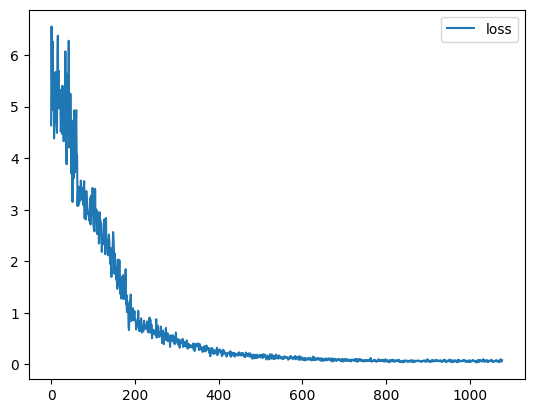

In [56]:
if __name__=='__main__':
    initial_time=time.time()
    if torch.cuda.is_available():
        device='cuda'
        print('now using cuda !')
    else:
        device='cpu'
        print('now using cpu !')
    dtype=torch.float32
    model=Mynetwork().to(device=device,dtype=dtype)
    
    from torch.nn import init

    for name, param in model.named_parameters():
        if 'weight' in name:
            init.normal_(param, mean=0, std=0.1)
        elif 'bias' in name:
            init.constant_(param, val=0)
    
    batch_size=512
    epoch=10000
    if debug:epoch=1
    consist_depth=5
    #training part 
    training(model,device,dtype,epoch=epoch,lr=0.001,batch_size=batch_size,consist_depth=consist_depth,use_lr_scheduler=True,boundary_func=fun1)
    
    print('program ended here \n terminal time: ', time.time()-initial_time)
    print(f'save model parameter in file name : model_para_batch{batch_size}_epoch{epoch}_consist_depth{consist_depth}.pth')